In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import math

import scipy
from scipy import stats

from numpy import (isscalar, r_, log, around, unique, asarray, zeros,
                   arange, sort, amin, amax, atleast_1d, sqrt, array,
                   compress, pi, exp, ravel, count_nonzero, sin, cos,
                   arctan2, hypot)


from scipy import optimize
from scipy import special

import figurefirst as fifi
import time

from matplotlib import gridspec
import metpy
from metpy import calc

import statsmodels
import statsmodels.stats.api as sms
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [2]:
import temporal_functions

In [3]:
#df1=pd.read_hdf('10.20.20_all.hdf') % no vertical sensors in this experiment
df2=pd.read_hdf('7.7.21_all.hdf')
df3=pd.read_hdf('9.26.21_all.hdf')
df4=pd.read_hdf('10.29.21_all.hdf')
df5=pd.read_hdf('10.30.21_all.hdf')
df6=pd.read_hdf('1.8.22_all.hdf')
df7=pd.read_hdf('1.11.22_all.hdf')
df8=pd.read_hdf('1.15.22_all.hdf')
df9=pd.read_hdf('4.30.22_all.hdf')
df10=pd.read_hdf('5.1.22_all.hdf')
df11=pd.read_hdf('5.2.22_all.hdf')
df12=pd.read_hdf('6.1.22_all.hdf')
df13=pd.read_hdf('6.3.22_all.hdf')
df14=pd.read_hdf('6.7.22_all.hdf')
df15=pd.read_hdf('6.8.22_all.hdf')
df16=pd.read_hdf('6.22.22_all.hdf')

# Calculate lags and make a df for each data collection

In [4]:
df=df16
time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(df.time.iloc[0]))

'2022-06-22 11:33:23'

In [5]:
print(df.keys())

Index(['millis_2', 'lat_2', 'lon_2', 'gps_time_2', 'gps_date_2', 'wind_2',
       'gps_date_str_2', 'year_2', 'month_2', 'day_2',
       ...
       'Z_6', 'X_7', 'Y_7', 'Z_7', 'X_8', 'Y_8', 'Z_8',
       'X_9_verticallyorientated', 'Y_9_verticallyorientated',
       'Z_9_verticallyorientated'],
      dtype='object', length=185)


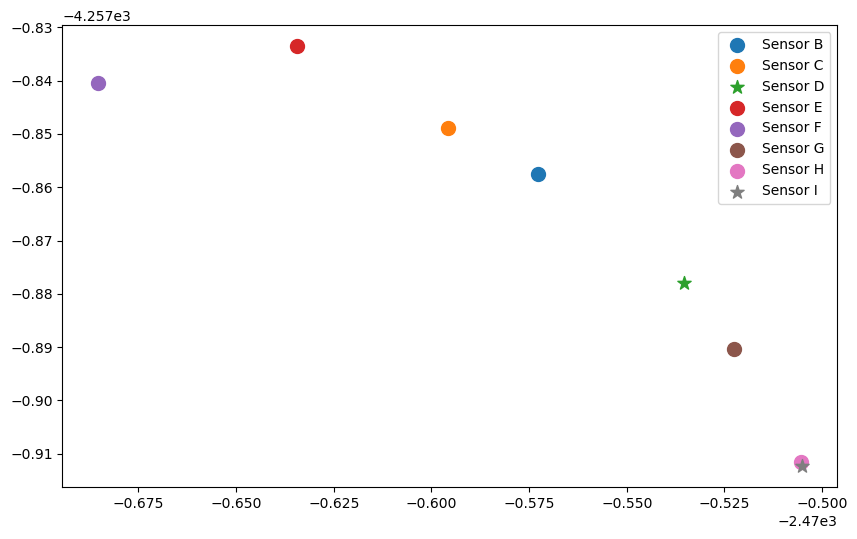

In [6]:
#get a sense of where sensors were located
#vertically oriented sensors were paired on a tripod with another sensor
#using this to determine which sensor to use for horizontal speed comparison
fig=plt.figure(figsize=(10,6))
#plt.scatter(df.X_1.iloc[0],df.Y_1.iloc[0], s=100, label='Sensor A')
plt.scatter(df.X_2.iloc[0],df.Y_2.iloc[0], s=100, label='Sensor B')
plt.scatter(df.X_3.iloc[0],df.Y_3.iloc[0], s=100, label='Sensor C')
plt.scatter(df.X_4_verticallyorientated.iloc[0],df.Y_4_verticallyorientated.iloc[0], s=100, marker='*', label='Sensor D')
plt.scatter(df.X_5.iloc[0],df.Y_5.iloc[0], s=100, label='Sensor E')
plt.scatter(df.X_6.iloc[0],df.Y_6.iloc[0], s=100, label='Sensor F')
plt.scatter(df.X_7.iloc[0],df.Y_7.iloc[0], s=100, label='Sensor G')
plt.scatter(df.X_8.iloc[0],df.Y_8.iloc[0], s=100, label='Sensor H')
plt.scatter(df.X_9_verticallyorientated.iloc[0],df.Y_9_verticallyorientated.iloc[0], marker='*', s=100, label='Sensor I' )
plt.legend()

In [7]:
#loglags=np.arange(300,6300,300) #lags from 0-10mins, 30 sec intervals -- excluding lag zero since there is no standard dev over a period of 0

loglags= array([100, 300,  600,  900, 1200, 1500, 1800, 2100, 2400, 2700, 3000, 3300, 3600, 3900, 4200, 4500, 4800, 5100, 5400, 5700, 6000])

totalrows=np.arange(0,int(len(df)/10000))

avg_vert_V = np.empty((len(totalrows), 0)).tolist()
avg_s2 = np.empty((len(totalrows), 0)).tolist()
avg_d = np.empty((len(totalrows), 0)).tolist()
std_vert_V = np.empty((len(totalrows), 0)).tolist()
std_s2 = np.empty((len(totalrows), 0)).tolist()
std_d= np.empty((len(totalrows), 0)).tolist()
frictionalvel= np.empty((len(totalrows), 0)).tolist()

In [8]:
i=0
for j in totalrows:
    avg_vert_V[i], avg_s2[i], avg_d[i], std_vert_V[i], std_s2[i], std_d[i], frictionalvel[i] = temporal_functions.vert_temporal_analysis(df.V_9_verticallyorientated,  df.U_8,  df.V_8, df.S2_8, df.D_8, lagarray=loglags, method='forward')
    i=i+1

In [9]:
#convert to df
df_avg_V=pd.DataFrame(avg_vert_V, index=range(len(avg_vert_V)), columns=loglags)
df_avg_s2=pd.DataFrame(avg_s2, index=range(len(avg_s2)), columns=loglags)
df_avg_d=pd.DataFrame(avg_d, index=range(len(avg_d)), columns=loglags)

df_std_V=pd.DataFrame(std_vert_V, index=range(len(std_vert_V)), columns=loglags)
df_std_s2=pd.DataFrame(std_s2, index=range(len(std_s2)), columns=loglags)
df_std_d=pd.DataFrame(std_d, index=range(len(std_d)), columns=loglags)

df_frictionalvel=pd.DataFrame(frictionalvel, index=range(len(frictionalvel)), columns=loglags)

In [10]:
full_df=pd.DataFrame(columns = ['frictional_vel', 'vert_vel_avg','horizontal_speed_avg', 'horizontal_dir_avg','vert_vel_std','horizontal_speed_std', 'horizontal_dir_std'])

i=0


for k in df_avg_V.index:
    xtra = {'vert_vel_avg': df_avg_V.iloc[k,:], 
           'horizontal_speed_avg': df_avg_s2.iloc[k,:],
           'horizontal_dir_avg': df_avg_d.iloc[k,:],
            
           'vert_vel_std' :df_std_V.iloc[k,:],
            'horizontal_speed_std': df_std_s2.iloc[k,:],
           'horizontal_dir_std': df_std_d.iloc[k,:],
            'frictional_vel': df_frictionalvel.iloc[k,:],
            }
    full_df= full_df.append(pd.DataFrame(xtra))
i=i+1

/var/folders/0c/q32x1j5s1zqg0747td81nt840000gn/T/ipykernel_63350/1770279080.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_df= full_df.append(pd.DataFrame(xtra))
/var/folders/0c/q32x1j5s1zqg0747td81nt840000gn/T/ipykernel_63350/1770279080.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_df= full_df.append(pd.DataFrame(xtra))
/var/folders/0c/q32x1j5s1zqg0747td81nt840000gn/T/ipykernel_63350/1770279080.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_df= full_df.append(pd.DataFrame(xtra))
/var/folders/0c/q32x1j5s1zqg0747td81nt840000gn/T/ipykernel_63350/1770279080.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

In [11]:
full_df

,frictional_vel,vert_vel_avg,horizontal_speed_avg,horizontal_dir_avg,vert_vel_std,horizontal_speed_std,horizontal_dir_std
100,0.071511,0.078000,0.409000,252.307003,0.211547,0.090637,0.407317
300,0.142317,0.622567,0.722800,214.862753,0.268571,0.323241,0.528632
600,0.281811,0.301633,0.694817,276.469834,0.338700,0.506614,0.848982
900,0.250825,0.194056,0.959378,327.168843,0.424642,0.580891,1.216441
1200,0.289124,0.487367,1.047717,179.915842,0.378608,0.523222,0.606613
...,...,...,...,...,...,...,...
4800,0.445935,0.316067,1.080465,29.667835,0.492338,0.588811,1.286447
5100,0.410862,0.374278,1.227720,164.631154,0.479715,0.651789,0.795519
5400,0.331705,0.346881,1.339574,147.599848,0.423720,0.723068,0.679463
5700,0.620788,0.308323,1.175589,213.836485,0.548036,0.678981,1.181604


In [12]:
full_df.reset_index(inplace=True)
full_df.rename(columns={'index':'time'}, inplace=True)

In [13]:
full_df[['environment']]=.4
full_df[['group']]=16
full_df.horizontal_dir_std=full_df.horizontal_dir_std*180/np.pi #make it degrees again
full_df.time=full_df.time*.1 #fix the time to be accurate 
full_df['cos_horizontal_dir_avg']=np.cos(full_df.horizontal_dir_avg*np.pi/180)
full_df['sin_horizontal_dir_avg']=np.sin(full_df.horizontal_dir_avg*np.pi/180)
full_df['normed_vert_vel']=full_df.vert_vel_std/full_df.frictional_vel
full_df['turbulent_intensity']=full_df.horizontal_speed_std/full_df.horizontal_speed_avg


In [14]:
full_df.to_hdf('6.22.22_verticaltemporal.hdf', key='/windgps')

# Looking at all lagged dataframes

In [15]:
#t1=pd.read_hdf('10.20.20_verticaltemporal.hdf') # no vertical sensors in this dataset
t2=pd.read_hdf('dfs_vertical/7.7.21_verticaltemporal.hdf')
t3=pd.read_hdf('dfs_vertical/9.26.21_verticaltemporal.hdf')
t4=pd.read_hdf('dfs_vertical/10.29.21_verticaltemporal.hdf')
t5=pd.read_hdf('dfs_vertical/10.30.21_verticaltemporal.hdf')
t6=pd.read_hdf('dfs_vertical/1.8.22_verticaltemporal.hdf')
t7=pd.read_hdf('dfs_vertical/1.11.22_verticaltemporal.hdf')
t8=pd.read_hdf('dfs_vertical/1.15.22_verticaltemporal.hdf')
t9=pd.read_hdf('dfs_vertical/4.30.22_verticaltemporal.hdf')
t10=pd.read_hdf('dfs_vertical/5.1.22_verticaltemporal.hdf')
t11=pd.read_hdf('dfs_vertical/5.2.22_verticaltemporal.hdf')
t12=pd.read_hdf('dfs_vertical/6.1.22_verticaltemporal.hdf')
t13=pd.read_hdf('dfs_vertical/6.3.22_verticaltemporal.hdf')
t14=pd.read_hdf('dfs_vertical/6.7.22_verticaltemporal.hdf')
t15=pd.read_hdf('dfs_vertical/6.8.22_verticaltemporal.hdf')
t16=pd.read_hdf('dfs_vertical/6.22.22_verticaltemporal.hdf')

In [16]:
alltemp=[t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13,t14,t15,t16]

In [17]:
for i in range(0,15):
    alltemp[i]['vert_turb_intensity']=alltemp[i]['vert_vel_std']/np.abs(alltemp[i]['horizontal_speed_avg'])

In [18]:
alltempconcat=pd.concat(alltemp)

In [19]:
alltempconcat=alltempconcat.reset_index(inplace=False)
alltempconcat

,index,time,frictional_vel,vert_vel_avg,horizontal_speed_avg,horizontal_dir_avg,vert_vel_std,horizontal_speed_std,horizontal_dir_std,environment,group,cos_horizontal_dir_avg,sin_horizontal_dir_avg,normed_vert_vel,turbulent_intensity,vert_turb_intensity
0,0,10.0,0.119837,-0.082500,1.331900,249.160021,0.207424,0.264294,9.133247,0.4,2,-0.355759,-0.934578,1.730885,0.198434,0.155735
1,1,30.0,0.169649,0.062767,4.318000,277.667051,0.304615,1.257511,9.756071,0.4,2,0.133416,-0.991060,1.795559,0.291225,0.070545
2,2,60.0,0.107158,0.057500,1.196150,205.044305,0.326349,0.448192,44.248622,0.4,2,-0.905981,-0.423319,3.045484,0.374695,0.272833
3,3,90.0,0.339034,-0.002156,1.710144,239.498644,0.416695,0.781072,24.288213,0.4,2,-0.507559,-0.861617,1.229066,0.456729,0.243661
4,4,120.0,0.218215,0.039175,2.618258,251.850884,0.382829,0.796720,16.605147,0.4,2,-0.311491,-0.950249,1.754370,0.304294,0.146215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5560,247,480.0,0.335265,0.273479,0.935544,135.507520,0.440143,0.464697,76.697187,0.4,16,-0.713342,0.700816,1.312819,0.496713,0.470467
5561,248,510.0,0.319110,0.193706,1.506757,130.681991,0.457837,0.792592,50.822477,0.4,16,-0.651860,0.758339,1.434730,0.526025,0.303856
5562,249,540.0,0.447972,0.246765,1.045107,299.529526,0.411904,0.712485,77.400311,0.4,16,0.492872,-0.870102,0.919487,0.681734,0.394126
5563,250,570.0,0.502830,0.200935,1.118095,151.402047,0.528598,0.616115,64.238926,0.4,16,-0.878000,0.478660,1.051247,0.551040,0.472767


## Plotting

In [20]:
desertchunks=pd.concat([alltemp[5], alltemp[6],alltemp[10],alltemp[11]])
forestchunks=pd.concat([alltemp[0], alltemp[2],alltemp[12],alltemp[13], alltemp[14]])
urbanchunks=pd.concat([alltemp[1], alltemp[3],alltemp[4],alltemp[7], alltemp[8],alltemp[9]])
desert=5,6,10,11
forest=0,2,12,13,14
urban=1,3,4,7,8,9

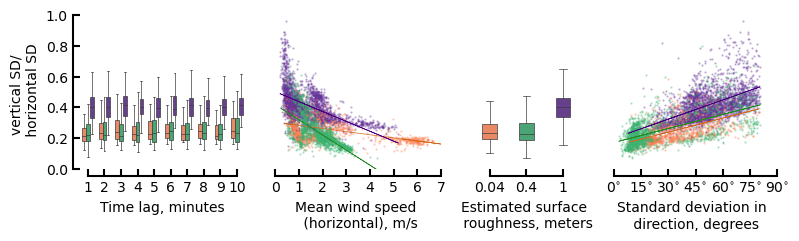

In [21]:
mpl.rcParams.update({'font.size': 10})

c=['mediumseagreen', 'rebeccapurple', 'mediumseagreen', 'rebeccapurple', 'rebeccapurple', 'coral', 'coral', 'rebeccapurple', 'rebeccapurple', 'rebeccapurple', 'coral', 'coral', 'mediumseagreen', 'mediumseagreen', 'mediumseagreen']

fig, ax =plt.subplots(nrows=1, ncols=4, figsize=(9,2), gridspec_kw={'width_ratios':[1.5,1.5,1,1.5]})


for i in range(0,15):
    ax[1].scatter(alltemp[i].horizontal_speed_avg, alltemp[i].vert_turb_intensity,  s=.4, color=c[i],alpha=.35, rasterized=True)
    ax[3].scatter(alltemp[i].horizontal_dir_std, alltemp[i].vert_turb_intensity,  s=.4, color=c[i], alpha=.35, rasterized=True)
    
#sns.boxplot(x='time', y='vert_vel_std', hue='environment', data=allt1, showfliers=False, palette=['steelblue', 'seagreen', 'purple',], width=.7, ax=ax[0])    
minutesdf=alltempconcat.loc[alltempconcat['time'].isin([60,120,180,240,300,360,420,480,540,600])]
#minutesdf['abs_ver_vel']=np.abs()
sns.boxplot(x=minutesdf.time, y=minutesdf.vert_turb_intensity, hue=minutesdf.environment, showfliers=False, palette=['coral', 'mediumseagreen', 'rebeccapurple',], width=.7, linewidth=.5, ax=ax[0])    
ax[0].get_legend().remove()

ax[0].set_xticklabels([1,2,3,4,5,6,7,8,9,10])
#ax[0].set_xlabel('Time lags, minutes')
#ax[0].legend(bbox_to_anchor=(3,1))

sns.boxplot(x=alltempconcat.environment, y=alltempconcat.vert_turb_intensity, showfliers=False, palette=['coral', 'mediumseagreen', 'rebeccapurple',], width=.4, linewidth=.5, ax=ax[2])

#xticks=np.arange(0,6300,300)
#ax[0].set_xticklabels(xticks)

# add mean lines for ax2
slope, intercept = np.polyfit(desertchunks.horizontal_speed_avg, desertchunks.vert_turb_intensity, 1)
abline_values = [slope * i + intercept for i in desertchunks.horizontal_speed_avg]
ax[1].plot(desertchunks.horizontal_speed_avg, abline_values, 'chocolate', linewidth=.5)
slope, intercept = np.polyfit(forestchunks.horizontal_speed_avg, forestchunks.vert_turb_intensity, 1)
abline_values = [slope * i + intercept for i in forestchunks.horizontal_speed_avg]
ax[1].plot(forestchunks.horizontal_speed_avg, abline_values, 'forestgreen', linewidth=.5)
slope, intercept = np.polyfit(urbanchunks.horizontal_speed_avg, urbanchunks.vert_turb_intensity, 1)
abline_values = [slope * i + intercept for i in urbanchunks.horizontal_speed_avg]
ax[1].plot(urbanchunks.horizontal_speed_avg, abline_values, 'indigo', linewidth=.5)


# add mean lines for ax4
slope, intercept = np.polyfit(desertchunks.horizontal_dir_std, desertchunks.vert_turb_intensity, 1)
abline_values = [slope * i + intercept for i in desertchunks.horizontal_dir_std]
ax[3].plot(desertchunks.horizontal_dir_std, abline_values, 'chocolate', linewidth=.5)
slope, intercept = np.polyfit(forestchunks.horizontal_dir_std, forestchunks.vert_turb_intensity, 1)
abline_values = [slope * i + intercept for i in forestchunks.horizontal_dir_std]
ax[3].plot(forestchunks.horizontal_dir_std, abline_values, 'forestgreen', linewidth=.5)
slope, intercept = np.polyfit(urbanchunks.horizontal_dir_std, urbanchunks.vert_turb_intensity, 1)
abline_values = [slope * i + intercept for i in urbanchunks.horizontal_dir_std]
ax[3].plot(urbanchunks.horizontal_dir_std, abline_values, 'indigo', linewidth=.5)

ax[2].set_xticklabels([.04, .4, 1])
ax[0].set_ylabel('vertical SD/ \n horizontal SD')
ax[0].set_xlabel('Time lag, minutes')  
ax[1].set_xlabel('Mean wind speed \n (horizontal), m/s')
ax[2].set_ylabel('')
ax[3].set_xlabel('Standard deviation in \n direction, degrees')
ax[2].set_xlabel('Estimated surface \n roughness, meters')
ax[0].grid(False)
ax[1].grid(False)
ax[2].grid(False)
ax[3].grid(False)

ax[0].set_ylim(0,1)
ax[1].set_ylim(0,1)
ax[2].set_ylim(0,1)
ax[3].set_ylim(0,1)
ax[1].set_xlim(0,7)
# Set log scale and spines

ax[0].set_facecolor('white')
ax[1].set_facecolor('white')
ax[2].set_facecolor('white')


fifi.mpl_functions.adjust_spines(ax[0], ['left', 'bottom'],
                                #yticks=np.arange(0,17,2)/10,
                                 yticks=[0,.2,.4,.6,.8,1],
                                 tick_length=5,
                                 spine_locations={'left': 5, 'bottom': 5},
                                 linewidth=1.5)
fifi.mpl_functions.adjust_spines(ax[1], [ 'bottom'],
                                 yticks=[0,.2,.4,.6,.8,1],
                                 xticks=np.arange(0,8,1),
                                 tick_length=5,
                                 spine_locations={'bottom': 5},
                                 linewidth=1.5)
fifi.mpl_functions.adjust_spines(ax[2], [ 'bottom'],
                                 yticks=[0,.2,.4,.6,.8,1],
                                 tick_length=5,
                                 spine_locations={'bottom': 5},
                                 linewidth=1.5)

fifi.mpl_functions.adjust_spines(ax[3], [ 'bottom'],
                                 yticks=[0,.2,.4,.6,.8,1],
                                 xticks=[0,15,30,45,60,75,90],
                                 tick_length=5,
                                 spine_locations={ 'bottom': 5},
                                 linewidth=1.5)
evenxticks=np.arange(0, 100, 15)
xticklabels=[['$' + str(x) + '^{\circ}$' + '',] for x in evenxticks]
xticklabels=np.ravel(xticklabels)
ax[3].set_xticklabels(xticklabels)


fig.savefig('regression_variables_vertical.svg', transparent=True, dpi=1200, bbox_inches='tight', format='svg')


# Regression analysis

In [22]:
alltemporal=alltempconcat
alltemporal['vert_turb_intensity']=alltemporal.vert_vel_std/alltemporal.horizontal_speed_avg 

In [23]:
#normalize pandas columns
N=len(alltemporal)+1
normalized_data = alltemporal.iloc[:,0:N].apply(lambda iterator: ((iterator - iterator.mean())/iterator.std()).round(7))

In [24]:
mod = smf.ols(formula='vert_turb_intensity ~ environment*horizontal_dir_std+ time*horizontal_dir_std', data=normalized_data)
res = mod.fit(cov_type='cluster', cov_kwds={'groups': normalized_data.group})
#res=mod.fit()
print(res.summary())

                             OLS Regression Results                            
Dep. Variable:     vert_turb_intensity   R-squared:                       0.611
Model:                             OLS   Adj. R-squared:                  0.610
Method:                  Least Squares   F-statistic:                     52.01
Date:                 Wed, 01 Feb 2023   Prob (F-statistic):           1.51e-08
Time:                         19:35:17   Log-Likelihood:                -5271.1
No. Observations:                 5565   AIC:                         1.055e+04
Df Residuals:                     5559   BIC:                         1.059e+04
Df Model:                            5                                         
Covariance Type:               cluster                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
In

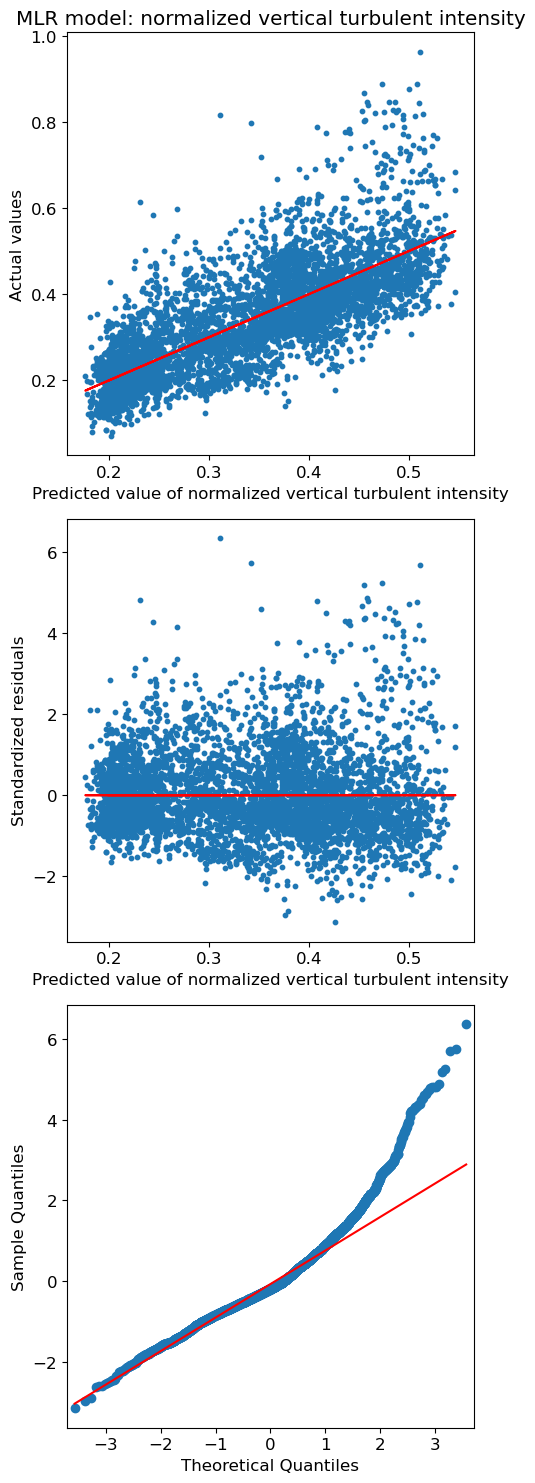

In [41]:

mod = smf.ols(formula='vert_turb_intensity~ environment*horizontal_dir_std + time*horizontal_dir_std', data=alltemporal)
res = mod.fit(cov_type='cluster', cov_kwds={'groups': alltemporal.group})
mpl.rcParams.update({'font.size': 12})

fig, ax =plt.subplots(nrows=3, ncols=1, figsize=(5,15), layout='tight')


slope, intercept = np.polyfit(res.fittedvalues, alltemporal.vert_turb_intensity, 1)
abline_values = [slope * i + intercept for i in res.fittedvalues]

ax[0].set_title('MLR model: normalized vertical turbulent intensity')
ax[0].scatter(res.fittedvalues, alltemporal.vert_turb_intensity, s=10, rasterized=True)
ax[0].plot(res.fittedvalues, abline_values, 'r', rasterized=True )
ax[0].set_xlabel ('Predicted value of normalized vertical turbulent intensity')
ax[0].set_ylabel ('Actual values')
#ax[0].set_xlim(-5,90)
#ax[0].set_ylim(-5,90)

slope, intercept = np.polyfit(res.fittedvalues, res.resid_pearson, 1)
abline_values = [slope * i + intercept for i in res.fittedvalues]

ax[1].scatter(res.fittedvalues, res.resid_pearson, s=10, rasterized=True)
ax[1].plot(res.fittedvalues, abline_values, 'r', rasterized=True )
ax[1].set_xlabel ('Predicted value of normalized vertical turbulent intensity')
ax[1].set_ylabel ('Standardized residuals')


sm.qqplot(res.resid_pearson, line='q', ax=ax[2], rasterized=True )
plt.show()
#
fig.savefig('regressionresidualtests_vertical.svg', dpi=600, format='svg')


## Calculating 10 min means for horizonal speed and vert vel (supplemental figure 7)

In [27]:
df=df16

In [30]:
dfsegs = temporal_functions.split_df(df[['V_9_verticallyorientated', 'S2_8' ]])

In [31]:
avg_s2_v = temporal_functions.avg_df(dfsegs)
std_s2_v = temporal_functions.std_df(dfsegs)
avg_s2_v = avg_s2_v.T
std_s2_v = std_s2_v.T


In [32]:
avg_s2_v = avg_s2_v.rename(columns={'V_9_verticallyorientated': 'vert_vel_avg', 
                         'S2_8': 'horizontal_speed_avg'} )
std_s2_v = std_s2_v.rename(columns={'V_9_verticallyorientated': 'vert_vel_std', 
                         'S2_8': 'horizontal_speed_std'} )

In [33]:
new1 = pd.concat([avg_s2_v,std_s2_v], axis=1)

In [34]:
new1['environment'] = .4
new1['group'] = 16

new1= new1.reset_index(inplace=False)

In [35]:
new1

,index,vert_vel_avg,horizontal_speed_avg,vert_vel_std,horizontal_speed_std,environment,group
0,0,0.208902,1.065300,0.504397,0.607172,0.4,16
1,1,0.233427,1.146108,0.537361,0.667417,0.4,16
2,2,0.262482,1.024008,0.456538,0.546670,0.4,16
3,3,0.201583,1.208017,0.560302,0.612320,0.4,16
4,4,0.403353,0.959697,0.451047,0.574751,0.4,16
5,5,0.373643,0.940773,0.415934,0.563439,0.4,16
6,6,0.284665,1.465945,0.467111,0.737613,0.4,16
7,7,0.473108,1.361127,0.540743,0.794008,0.4,16
8,8,0.317202,1.281592,0.470703,0.635988,0.4,16
9,9,0.343748,1.153582,0.435059,0.543516,0.4,16


In [36]:
new1.to_hdf('6.22.22_10minavg.hdf', key='/windgps')

### Read in all 10-minute averaged dfs

In [37]:
#df1=pd.read_hdf('10.20.20_all.hdf')
dfavg2=pd.read_hdf('7.7.21_10minavg.hdf', key='/windgps')
dfavg3=pd.read_hdf('9.26.21_10minavg.hdf')
dfavg4=pd.read_hdf('10.29.21_10minavg.hdf')
dfavg5=pd.read_hdf('10.30.21_10minavg.hdf')
dfavg6=pd.read_hdf('1.8.22_10minavg.hdf')
dfavg7=pd.read_hdf('1.11.22_10minavg.hdf')
dfavg8=pd.read_hdf('1.15.22_10minavg.hdf')
dfavg9=pd.read_hdf('4.30.22_10minavg.hdf')
dfavg10=pd.read_hdf('5.1.22_10minavg.hdf')
dfavg11=pd.read_hdf('5.2.22_10minavg.hdf')
dfavg12=pd.read_hdf('6.1.22_10minavg.hdf')
dfavg13=pd.read_hdf('6.3.22_10minavg.hdf')
dfavg14=pd.read_hdf('6.7.22_10minavg.hdf')
dfavg15=pd.read_hdf('6.8.22_10minavg.hdf')
dfavg16=pd.read_hdf('6.22.22_10minavg.hdf')

In [38]:
avglist= [dfavg2,dfavg3,dfavg4,dfavg5,dfavg6,dfavg7,dfavg8,dfavg9,dfavg10,dfavg11, dfavg12,dfavg13,dfavg14,dfavg15,dfavg16 ]
avgs = pd.concat([dfavg2,dfavg3,dfavg4,dfavg5,dfavg6,dfavg7,dfavg8,dfavg9,dfavg10,dfavg11, dfavg12,dfavg13,dfavg14,dfavg15,dfavg16 ])

In [39]:
desertavg=pd.concat([avglist[5], avglist[6],avglist[10],avglist[11]])
forestavg=pd.concat([avglist[0], avglist[2],avglist[12],avglist[13], avglist[14]])
urbanavg=pd.concat([avglist[1], avglist[3],avglist[4],avglist[7], avglist[8],avglist[9]])
desert=5,6,10,11
forest=0,2,12,13,14
urban=1,3,4,7,8,9

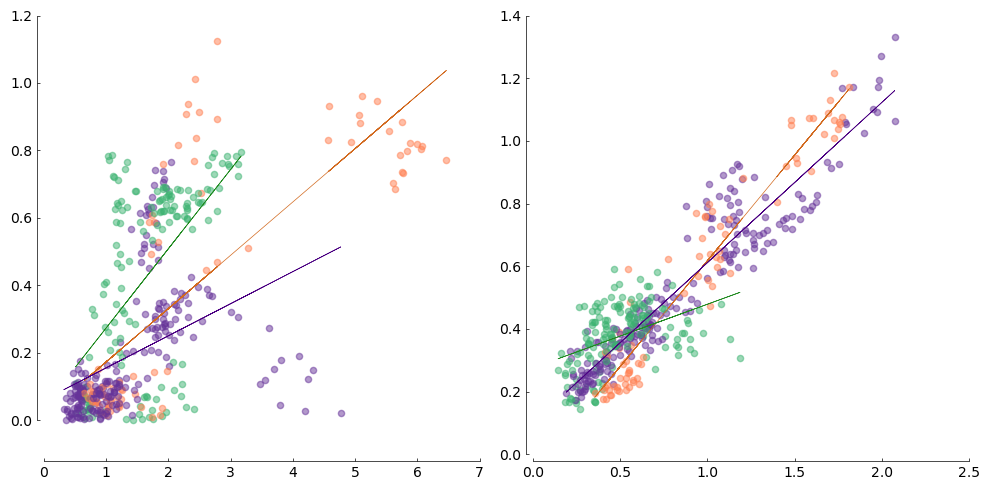

In [40]:
mpl.rcParams.update({'font.size': 10})

c=['mediumseagreen', 'rebeccapurple', 'mediumseagreen', 'rebeccapurple', 'rebeccapurple', 'coral', 'coral', 'rebeccapurple', 'rebeccapurple', 'rebeccapurple', 'coral', 'coral', 'mediumseagreen', 'mediumseagreen', 'mediumseagreen']

fig, ax = plt.subplots(figsize=(10,5), ncols=2, layout='tight')
for i in range (0,15):
    ax[0].scatter(avglist[i].horizontal_speed_avg, np.abs(avglist[i].vert_vel_avg), s=20, alpha=.5, linewidth=None, c=c[i], rasterized=True)

    
# add mean lines
slope, intercept = np.polyfit(desertavg.horizontal_speed_avg, np.abs(desertavg.vert_vel_avg), 1)
abline_values = [slope * i + intercept for i in desertavg.horizontal_speed_avg]
ax[0].plot(desertavg.horizontal_speed_avg, abline_values, 'chocolate', linewidth=.5)
slope, intercept = np.polyfit(forestavg.horizontal_speed_avg, np.abs(forestavg.vert_vel_avg), 1)
abline_values = [slope * i + intercept for i in forestavg.horizontal_speed_avg]
ax[0].plot(forestavg.horizontal_speed_avg, abline_values, 'forestgreen', linewidth=.5)
slope, intercept = np.polyfit(urbanavg.horizontal_speed_avg, np.abs(urbanavg.vert_vel_avg), 1)
abline_values = [slope * i + intercept for i in urbanavg.horizontal_speed_avg]
ax[0].plot(urbanavg.horizontal_speed_avg, abline_values, 'indigo', linewidth=.5)


for i in range (0,15):
    ax[1].scatter(avglist[i].horizontal_speed_std, np.abs(avglist[i].vert_vel_std), s=20, alpha=.5, linewidth=None, c=c[i], rasterized=True)

    
# add mean lines
slope, intercept = np.polyfit(desertavg.horizontal_speed_std, desertavg.vert_vel_std, 1)
abline_values = [slope * i + intercept for i in desertavg.horizontal_speed_std]
ax[1].plot(desertavg.horizontal_speed_std, abline_values, 'chocolate', linewidth=.5)
slope, intercept = np.polyfit(forestavg.horizontal_speed_std, forestavg.vert_vel_std, 1)
abline_values = [slope * i + intercept for i in forestavg.horizontal_speed_std]
ax[1].plot(forestavg.horizontal_speed_std, abline_values, 'forestgreen', linewidth=.5)
slope, intercept = np.polyfit(urbanavg.horizontal_speed_std, urbanavg.vert_vel_std, 1)
abline_values = [slope * i + intercept for i in urbanavg.horizontal_speed_std]
ax[1].plot(urbanavg.horizontal_speed_std, abline_values, 'indigo', linewidth=.5)




    
#ax.axis("off")
ax[0].set_ylim(-0.1,1.2)
ax[0].set_xlim(0,7)
fifi.mpl_functions.adjust_spines(ax[0], ['left', 'bottom'],
                                yticks=np.arange(0,1.4, .2),
                                 xticks=np.arange(0,8,1),
                                 tick_length=2.5,
                                 spine_locations={'left': 5, 'bottom': 5},
                                 linewidth=0.5)

fifi.mpl_functions.adjust_spines(ax[1], ['left', 'bottom'],
                                yticks=np.arange(0,1.6, .2),
                                 xticks=np.arange(0,3,.5),
                                 tick_length=2.5,
                                 spine_locations={'left': 5, 'bottom': 5},
                                 linewidth=0.5)
fig.savefig("s2_vs_vert.svg", dpi=1200, format='svg', transparent=True)